In [1]:
import pandas as pd
import numpy as np

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('class label', np.unique(df_wine['Class label']))

class label [1 2 3]


In [0]:
from sklearn.model_selection import train_test_split
# y = Class label , X = other data
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [0]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [6]:
np.set_printoptions(precision=4)
mean_vecs = []

for label in range(1, 4):
  mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
  print('MX',label, ': ', mean_vecs[label-1])


MX 1 :  [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]
MX 2 :  [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]
MX 3 :  [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]


In [8]:
d = 13
S_W = np.zeros((d, d))

for label, mv in zip(range(1, 4), mean_vecs):
  class_scatter = np.zeros((d, d))

  for row in X_train_std[y_train == label]:
    row, mv = row.reshape(d, 1), mv.reshape(d, 1)
    class_scatter += (row - mv).dot((row - mv).T)
  S_W += class_scatter
print('클래스 내의 산포 행렬: ', S_W.shape[0],'x',S_W.shape[1])

클래스 내의 산포 행렬:  13 x 13


In [9]:
print('클래스 레이블 분포: ', np.bincount(y_train)[1:])

클래스 레이블 분포:  [41 50 33]


In [10]:
d = 13
S_W = np.zeros((d, d))

for label, mv in zip(range(1, 4), mean_vecs):
  class_scatter = np.cov(X_train_std[y_train==label].T, bias=True)
  S_W += class_scatter

print('스케일 조정된 클래스 내의 산포 행렬: ', S_W.shape[0],'x',S_W.shape[1])

스케일 조정된 클래스 내의 산포 행렬:  13 x 13


In [11]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)
d = 13
S_B = np.zeros((d, d))

for i, mean_vec in enumerate(mean_vecs):
  n = X_train[y_train == i + 1, :].shape[0]
  mean_vec = mean_vec.reshape(d, 1)
  S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('클래스 간의 산포 행렬: ', S_W.shape[0],'x',S_W.shape[1])


클래스 간의 산포 행렬:  13 x 13


In [12]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

print('내림차순의 고윳값 \n')
for eigen_val in eigen_pairs:
  print(eigen_val[0])

내림차순의 고윳값 

358.0042070133659
177.07768640666225
2.842170943040401e-14
2.2513016031041443e-14
1.800270811737676e-14
1.800270811737676e-14
1.578515719598725e-14
1.3662940131811948e-14
1.3662940131811948e-14
9.798790178197109e-15
9.798790178197109e-15
2.90135780637586e-15
9.905045812450375e-16


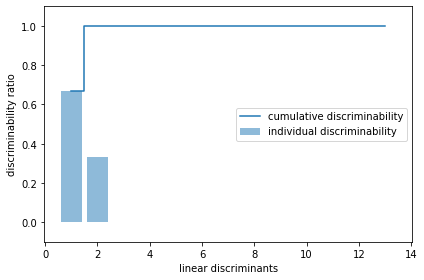

In [15]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
dum_discr = np.cumsum(discr)

import matplotlib.pyplot as plt

plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='individual discriminability')
plt.step(range(1, 14), dum_discr, where='mid', label='cumulative discriminability')

plt.ylabel('discriminability ratio')
plt.xlabel('linear discriminants')

plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [16]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
               eigen_pairs[1][1][:, np.newaxis].real))
print('행렬 W:\n', w)

행렬 W:
 [[-0.1484 -0.4093]
 [ 0.091  -0.1583]
 [-0.0168 -0.3536]
 [ 0.1487  0.322 ]
 [-0.0165 -0.0813]
 [ 0.1912  0.0841]
 [-0.7333  0.2828]
 [-0.0751 -0.0099]
 [ 0.002   0.0902]
 [ 0.2953 -0.2168]
 [-0.0327  0.274 ]
 [-0.3539 -0.0133]
 [-0.3918 -0.5954]]


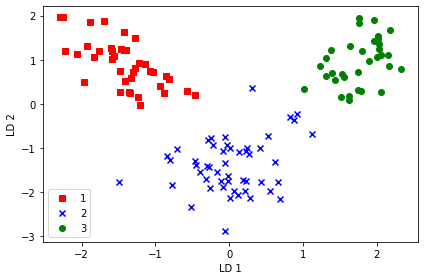

In [18]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
  plt.scatter(X_train_lda[y_train==l, 0],
              X_train_lda[y_train==l, 1] * (-1),
              c=c, label=l, marker=m)
  
plt.xlabel('LD 1')
plt.ylabel('LD 2')

plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [0]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
  # setting
  markers = ('s', 'x', 'o', '^', 'v')
  colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
  cmap = ListedColormap(colors[:len(np.unique(y))])

  # draw decision_regions
  x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  x2_min, x2_max = X[:, 1].min() -1, X[:, 1].max() + 1

  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         np.arange(x2_min, x2_max, resolution))
  
  # T is transpose
  Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
  Z = Z.reshape(xx1.shape)

  plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
  plt.xlim(xx1.min(), xx1.max())
  plt.ylim(xx2.min(), xx2.max())


  for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=X[y == cl, 0],
                y=X[y == cl, 1],
                alpha =0.8,
                c=colors[idx],
                marker=markers[idx],
                label=cl,
                edgecolor='black')

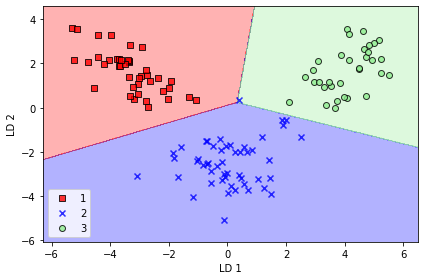

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

lr = LogisticRegression(solver='liblinear', multi_class='auto')
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')

plt.legend(loc='lower left')
plt.tight_layout()
plt.show()